# Classificação

Regressão (linear) ==> **estima um VALOR** (contínuo)  
Vs.  
Classificação ==> **prevê uma categoria/classe/rótulo** (discreto)  

#### MNIST: classificar digitos manuscritos (10 classes)
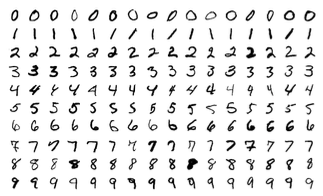

#### ImageNet: classificar variados objetos naturais (1000 classes)
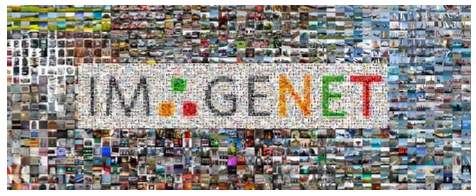

#### Kaggle: classificar imagens microscópicas de proteinas humanas 28 categorias
https://www.kaggle.com/c/human-protein-atlas-image-classification
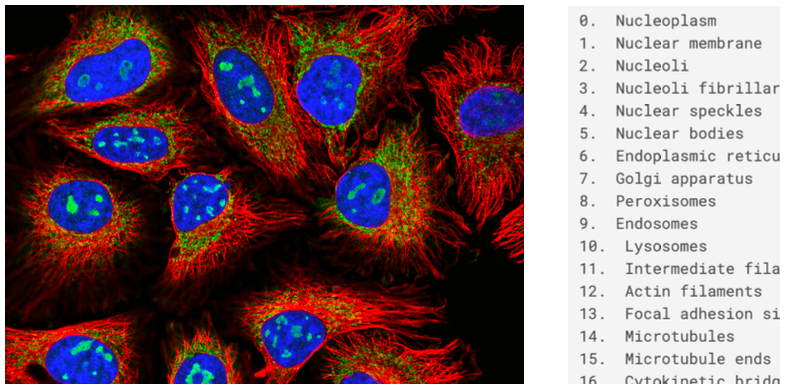

#### Kaggle: classificar malwares em 9 categorias
https://www.kaggle.com/c/malware-classification
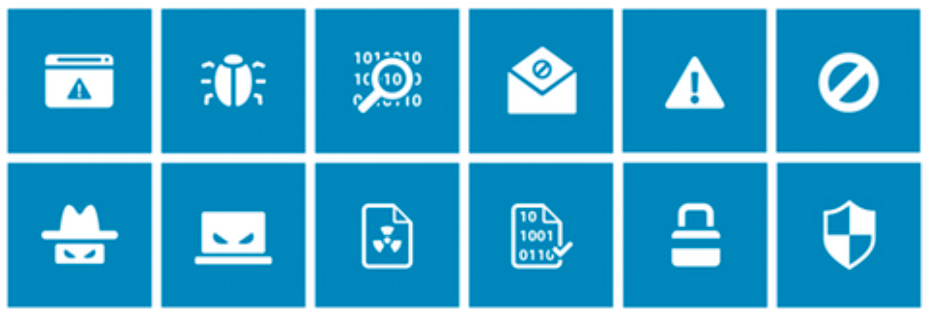

## Diferença na interpretação do resultado

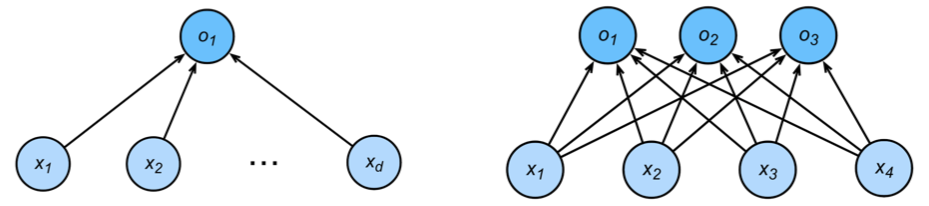

Saída da **Regressão** ==> um **único valor $\in \mathbb{R}$**

Saída da **Classificação** ==> um **vetor de valores** 

- ENTRADA: imagem 2x2 pixels de um animal: $x_1, x_2, x_3, x_4$
- SAÍDA: $\hat{y} = (cão?, gato?, galinha?)$
    - Exemplo: $y = (1, 0, 0)$ ou $(0, 1, 0)$ ou $(0, 0, 1)$ (**CODIFICAÇÃO ONE-HOT**)

## Formalizando...

\begin{split}
o_1 &= x_1 w_{11} + x_2 w_{12} + x_3 w_{13} + x_4 w_{14} + b_1,\\
o_2 &= x_1 w_{21} + x_2 w_{22} + x_3 w_{23} + x_4 w_{24} + b_2,\\
o_3 &= x_1 w_{31} + x_2 w_{32} + x_3 w_{33} + x_4 w_{34} + b_3.
\end{split}

Logo,

$\mathbf{o} = \mathbf{W} \mathbf{x} + \mathbf{b}$

A ideia é interpretar a saída do modelo como **probabilidades** que **maximizem a verossimilhança (_likelihood_)** dos dados.

Problemas em usar os valores de $o$ diretamente enquanto probabilidades:
1. Nada garante que a soma seja 1; e 
2. Qualquer um deles pode assumir valor negativo. 

Como resolver:
1. Divide pela soma para garantir que somem 1; e
2. Aplica exponenciação para garantir não-negatividade


**Função SOFTMAX (R. Duncan Luce, 1959)**   
$\hat{\mathbf{y}} = \mathrm{softmax}(\mathbf{o})\quad \text{onde}\quad \hat{y}_j = \frac{\exp(o_j)}{\sum_k \exp(o_k)}$

$\operatorname*{argmax}_j \hat y_j = \operatorname*{argmax}_j o_j$


Exemplo:  
Se $\hat{y}_1 = 0.85$, $\hat{y}_2 = 0.1$ e $\hat{y}_3 = 0.05$ $\implies \hat{y} = (1,0,0)$

### Considerando _mini batches_

$\begin{split}\begin{aligned} \mathbf{O} &= \mathbf{X} \mathbf{W} + \mathbf{b}, \\ \hat{\mathbf{Y}} & = \mathrm{softmax}(\mathbf{O}). \end{aligned}\end{split}$

## Função de Erro

Interpretação da probabilidade condicional estimada dada por softmax: $\hat{y}_1 = P(y=\text{cão} \mid \mathbf{x})$

Considerando um dataset $\{\mathbf{X}, \mathbf{Y}\}$ com $n$ exemplos, podemos comparar as estimativas com a realidade, verificando o quão provável são as classes reais de acordo com nosso modelo, dadas as características.

$P(\mathbf{Y} \mid \mathbf{X}) = \prod_{i=1}^n P(\mathbf{y}^{(i)} \mid \mathbf{x}^{(i)})$

Maximizar $P(\mathbf{Y} \mid \mathbf{X}) \iff$ Minimizar $-\log P(\mathbf{Y} \mid \mathbf{X}) = \sum_{i=1}^n -\log P(\mathbf{y}^{(i)} \mid \mathbf{x}^{(i)})$

Isso deve ser equivalente à $\sum_{i=1}^n l(\mathbf{y}^{(i)}, \hat{\mathbf{y}}^{(i)})$ (somatório do erro para todos os exemplos)

onde...   
$l(\mathbf{y}, \hat{\mathbf{y}}) = - \sum_{j=1}^q y_j \log \hat{y}_j$ (para $q$ classes) ==> chamado de **Erro de Entropia Cruzada (cross-entropy loss)**

Substituindo o valor de $\hat{y}_j$ mostrado anteriormente....

\begin{split}\begin{aligned}
l(\mathbf{y}, \hat{\mathbf{y}}) &=  - \sum_{j=1}^q y_j \log \frac{\exp(o_j)}{\sum_{k=1}^q \exp(o_k)} \\
&= \sum_{j=1}^q y_j \log \sum_{k=1}^q \exp(o_k) - \sum_{j=1}^q y_j o_j\\
&= \log \sum_{k=1}^q \exp(o_k) - \sum_{j=1}^q y_j o_j.
\end{aligned}\end{split}

E, finalmente, ao calcular as derivadas parciais em relação aos outputs, temos....

$\partial_{o_j} l(\mathbf{y}, \hat{\mathbf{y}}) = \frac{\exp(o_j)}{\sum_{k=1}^q \exp(o_k)} - y_j = \mathrm{softmax}(\mathbf{o})_j - y_j.$

O que é bem semelhante à Regressão Linear, onde o gradiente é a diferença entre a observação $y$ e a estimativa $\hat{y}$. Por isso, esse tipo de classificação é também conhecida como   
**REGRESSÃO SOFTMAX**.

## ESTUDO DE CASO: dataset _Fashion-MNIST_
Link: https://github.com/zalandoresearch/fashion-mnist

São 10 classes, cada uma representa 3 linhas da imagem

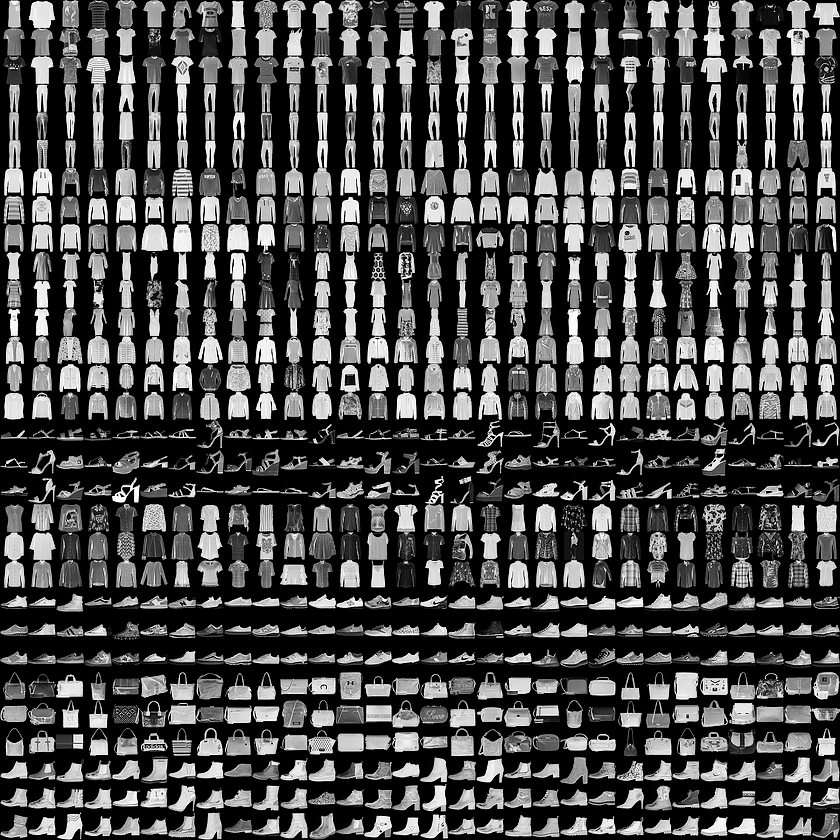

In [83]:
%matplotlib inline
#import d2l
from matplotlib import pyplot as plt
from mxnet import autograd, nd, context, gluon, image, init, np, npx
from mxnet.gluon import nn, rnn
import sys

In [84]:
#Download do dataset e armazenamento na memória principal
def load_data_fashion_mnist(batch_size, resize=None):
    dataset = gluon.data.vision
    trans = [dataset.transforms.ToTensor()]
    if resize:
        trans.insert(0, dataset.transforms.Resize(resize))
    trans = dataset.transforms.Compose(trans)
    #Conjunto de exemplos para treinamento
    mnist_train = dataset.FashionMNIST(train=True).transform_first(trans)
    #Conjunto de exemplos para teste/avaliação
    mnist_test = dataset.FashionMNIST(train=False).transform_first(trans)
    return (gluon.data.DataLoader(mnist_train, batch_size, shuffle=True,
                                  num_workers=get_dataloader_workers()),
            gluon.data.DataLoader(mnist_test, batch_size, shuffle=False,
                                  num_workers=get_dataloader_workers()))

#Threads de leitura
def get_dataloader_workers():
    return 0 if sys.platform.startswith('win') else 4

In [85]:
batch_size = 256
#treinamento, teste
train_iter, test_iter = load_data_fashion_mnist(batch_size)

### Inicializar parâmetros do modelo

In [86]:
# Cada exemplo = imagem $28 \times 28$ pixels ==> vetor de $784$ dimensões. 
num_inputs = 784
# 10 classes ==> saída da rede = vetor de 10 dimensões
num_outputs = 10

W = nd.random.normal(scale=0.01, shape=(num_inputs, num_outputs))
b = nd.zeros(num_outputs)

In [87]:
#Agregar o gradiente
W.attach_grad()
b.attach_grad()

### Definição da função Softmax

$
\mathrm{softmax}(\mathbf{X})_{ij} = \frac{\exp(X_{ij})}{\sum_k \exp(X_{ik})}
$

In [88]:
def softmax(X):
    X_exp = X.exp()
    partition = X_exp.sum(axis=1, keepdims=True)
    return X_exp / partition

In [89]:
X = nd.random.normal(shape=(2, 5))
X_prob = softmax(X)
#Apenas para conferência que a soma das probs = 1
X_prob, X_prob.sum(axis=1)

(
 [[0.16075376 0.41157168 0.20253745 0.13359816 0.0915389 ]
  [0.04129479 0.03124236 0.5120755  0.15276162 0.26262563]]
 <NDArray 2x5 @cpu(0)>,
 
 [0.99999994 0.99999994]
 <NDArray 2 @cpu(0)>)

### Definição do MODELO DE APRENDIZADO

Ou seja, ao final do treinamento e teste, quando a acurácia estiver OK, esta função usa a **INTELIGÊNCIA** da máquina, **W**, para prever a classe de cada novo exemplo.

In [90]:
def net(X):
    return softmax(nd.dot(X.reshape((-1, num_inputs)), W) + b)

### Definição da Função de Erro

In [91]:
def cross_entropy(y_hat, y):
    return - nd.pick(y_hat, y).log()

### Defnição da Acurácia do modelo 

In [92]:
#Devemos usar a previsão/classe de maior probabilidade
def accuracy(y_hat, y):
    return (y_hat.argmax(axis=1) == y.astype('float32')).mean().asscalar()

#Função de acurácia
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        y = y.astype('float32')
        acc_sum += (net(X).argmax(axis=1) == y).sum().asscalar()
        n += y.size
    return acc_sum / n

**OBS: como o modelo (`net`) foi inicializado com peos aleatórios, a acurácia deve ser parecida a um chute, ou seja, 0.1 para cada uma cdas 10 classes.**

In [95]:
print(evaluate_accuracy(test_iter, net)*100,'%')

13.22 %


### TREINAMENTO DO MODELO (APRENDIZADO)

In [96]:
#Minibatch SGD
def sgd(params, lr, batch_size):
    for param in params:
        param[:] = param - lr * param.grad / batch_size

#Algoritmo de treinamento
def train(net, train_iter, test_iter, loss, num_epochs, batch_size,
              params=None, lr=None, trainer=None):
    #para cada iteração/época
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        #para cada exemplo no conjunto de treinamento
        for X, y in train_iter:
            with autograd.record():
                y_hat = net(X) #calcula a previsão ˆy
                l = loss(y_hat, y).sum() #calcula o erro
            l.backward() #propaga o erro de volta
            if trainer is None:
                sgd(params, lr, batch_size)
            else:
                trainer.step(batch_size)
            y = y.astype('float32')
            train_l_sum += l.asscalar()
            #avalia a acurácia de treinamento
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().asscalar()
            n += y.size
        #avalia a acurácia de teste
        test_acc = evaluate_accuracy(test_iter, net)
        #Imprime parciais
        print('Epoca %d, Erro %.4f, Acurácia de treinamento %.3f,Acurácia de teste %.3f'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))

In [98]:
num_epochs, lr = 5, 0.1 #parâmetros: épocas e taxa de aprendizado
train(net, train_iter, test_iter, cross_entropy, num_epochs,
          batch_size, [W, b], lr)

Epoca 1, Erro 0.5052, Acurácia de treinamento 0.830,Acurácia de teste 0.837
Epoca 2, Erro 0.4898, Acurácia de treinamento 0.834,Acurácia de teste 0.840
Epoca 3, Erro 0.4783, Acurácia de treinamento 0.838,Acurácia de teste 0.843
Epoca 4, Erro 0.4687, Acurácia de treinamento 0.841,Acurácia de teste 0.843
Epoca 5, Erro 0.4624, Acurácia de treinamento 0.843,Acurácia de teste 0.845


### Previsão de um exemplo novo

array([<AxesSubplot:title={'center':'t-shirt\nt-shirt'}>,
       <AxesSubplot:title={'center':'trouser\ntrouser'}>,
       <AxesSubplot:title={'center':'pullover\npullover'}>,
       <AxesSubplot:title={'center':'pullover\nshirt'}>,
       <AxesSubplot:title={'center':'dress\ncoat'}>,
       <AxesSubplot:title={'center':'pullover\nshirt'}>], dtype=object)

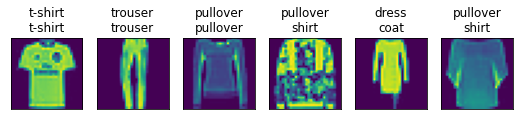

In [102]:
#AUXILIAR: Classes/categorias existentes no dataset
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        ax.imshow(numpy(img))
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

numpy = lambda x, *args, **kwargs: x.asnumpy(*args, **kwargs) #função anônima = alias
n = 6 #número de novos exemplos
for X, y in test_iter:
    break
true_labels = get_fashion_mnist_labels(y.asnumpy())

#Qual a classe com maior probabilidade?
pred_labels = get_fashion_mnist_labels(net(X).argmax(axis=1).asnumpy())

titles = [truelabel + '\n' + predlabel for truelabel, predlabel in zip(true_labels, pred_labels)]
show_images(X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

# Referências para estudo

## Seções 3.4, 3.5 e 3.6 de [Dive into Deep Learning](https://d2l.ai/index.html)